# Homework 5: Predicting a Burglary and finding the best model with cost benefit analysis

## Objective: Find the best classification model for finding burglaries

Create a classification model using random forest to predict BurgStatus.
- Combine the prediction results with the Logistic Regression and Decision Tree Model results.

### Section 2: Import Libraries

In [1]:
# Code Block 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Set display options and configurations
pd.set_option('display.max_columns', 1000)
plt.style.use('seaborn')
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

C:\Users\pyrom\AppData\Local\Temp\ipykernel_6328\1866808951.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Section 3:  Import Data

In [2]:
# Code Block 2

# Import the datasets
df_all = pd.read_csv('data/CantonPoliceDept_HW05.csv')

### Section 4: Create the datasets

#### 4.1 Create the X and y datasets

In [3]:
# Code Block 3

non_numeric_columns = df_all.select_dtypes(include=['object']).columns
X = df_all.drop(['Subzone', 'YEAR_WEEK', 'SUB_YEAR_WEEK', 'call_ALL_target', 'call_Burglary_target', 'ActualBurg', 'BurgStatus', 'BurgStatus2'], axis=1)
y = df_all['BurgStatus']

#### 4.2 Create the training and test datasets

In [4]:
# Code Block 6

# Split the data for training and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### 4.3 Create the scaled versions of X_train and X_test datasets

In [5]:
# Code Block 7

# Scale the data using Standard Scaler.
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)

### Section 5: Classification using Random Forest

##### Objective: 
Use Random Forest to create an OPTIMAL model (highest accuracy) and a DECISION model
(based on precision and recall).

#### 5.1 Using Random Forest create a model using the raw data

In [6]:
# Code Block 8

def train_and_evaluate(X_train, X_test, y_train, y_test, model, verbose=True):
    """
    Trains the model with training data and evaluates it using the test data.
    If verbose is True, detailed output is printed.
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    
    # Basic Metrics
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    if verbose:
        print(f'Accuracy Score: {accuracy:.4f}\n')
        print('Confusion Matrix:')
        print(confusion_matrix(y_test, predictions))
        print('\nClassification Report:')
        print(classification_report(y_test, predictions))
        print(f'ROC AUC Score: {roc_auc:.4f}\n')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        # Cross-Validation Scores
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print(f'CV ROC AUC: {cv_accuracy}\n')
    else:
        print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, ROC AUC: {roc_auc:.4f}')


Accuracy Score: 0.8149

Confusion Matrix:
[[1969  270]
 [ 388  927]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2239
           1       0.77      0.70      0.74      1315

    accuracy                           0.81      3554
   macro avg       0.80      0.79      0.80      3554
weighted avg       0.81      0.81      0.81      3554

ROC AUC Score: 0.8846



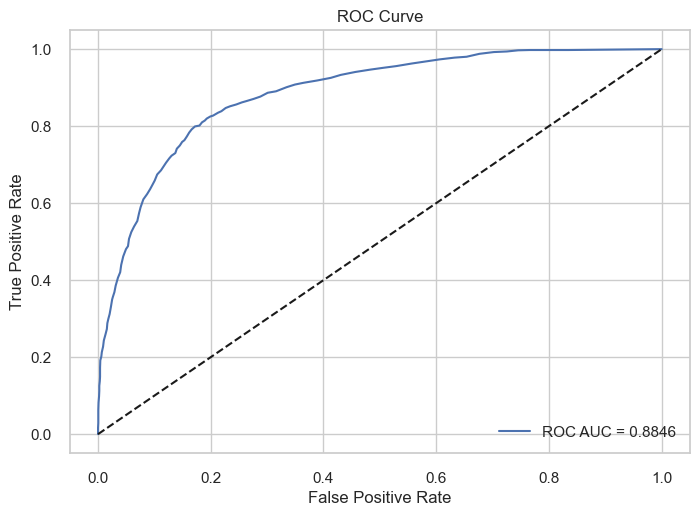

CV ROC AUC: [0.89030606 0.8716189  0.88491541 0.87422474 0.88502245]



In [7]:
# Code Block 9

# Run a Random Forest Classifier with default parameters
vartrain = X_train
vartest = X_test
model = RandomForestClassifier(random_state=21)

train_and_evaluate(vartrain, vartest, y_train, y_test, model)

#### 5.2 Fine-tune the model to find the OPTIMAL model

###### Manually Setting the Properties for Random Forest 

Depth 2: Accuracy = 0.7608
Depth 4: Accuracy = 0.7952
Depth 6: Accuracy = 0.8109
Depth 8: Accuracy = 0.8109
Depth 10: Accuracy = 0.8146
Depth 12: Accuracy = 0.8188
Depth 14: Accuracy = 0.8137
Depth 16: Accuracy = 0.8165
Depth 18: Accuracy = 0.8140
Depth 20: Accuracy = 0.8149
Depth 22: Accuracy = 0.8160


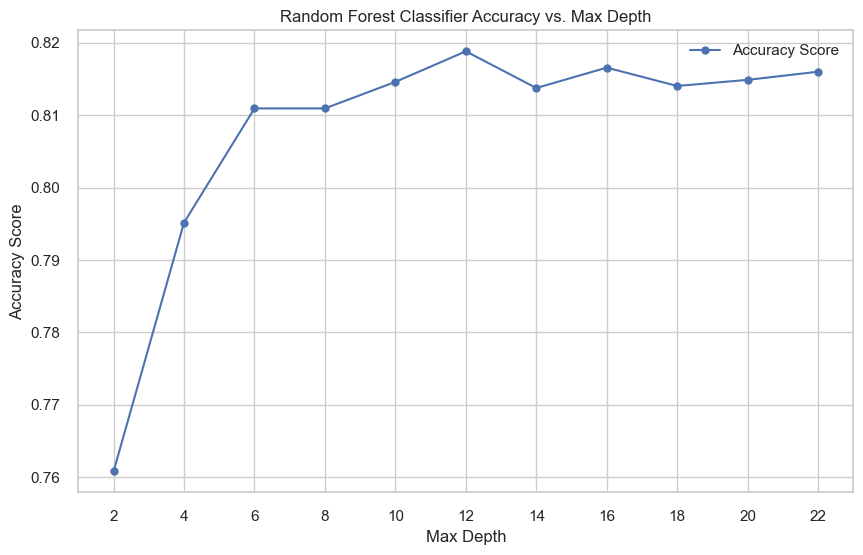

In [8]:
# Code Block 10
 
# With no set max_depth it can overfit on the training data

# List of depths to explore
depths = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

# Initialize an empty list to store accuracy scores
scores = []

# Iterate over each depth value
for d in depths:
    # Initialize the RandomForestClassifier with current depth
    classifier = RandomForestClassifier(max_depth=d, random_state=21)
    
    # Fit the model to the training data
    classifier.fit(X_train, y_train)
    
    # Evaluate the model on the test data and store the score
    score = classifier.score(X_test, y_test)
    scores.append(score)
    
    # Print the accuracy for the current depth
    print(f"Depth {d}: Accuracy = {score:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths, scores, '-o', label='Accuracy Score')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Classifier Accuracy vs. Max Depth')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

Accuracy Score: 0.9437

Confusion Matrix:
[[5195  142]
 [ 325 2629]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5337
           1       0.95      0.89      0.92      2954

    accuracy                           0.94      8291
   macro avg       0.94      0.93      0.94      8291
weighted avg       0.94      0.94      0.94      8291

ROC AUC Score: 0.9870



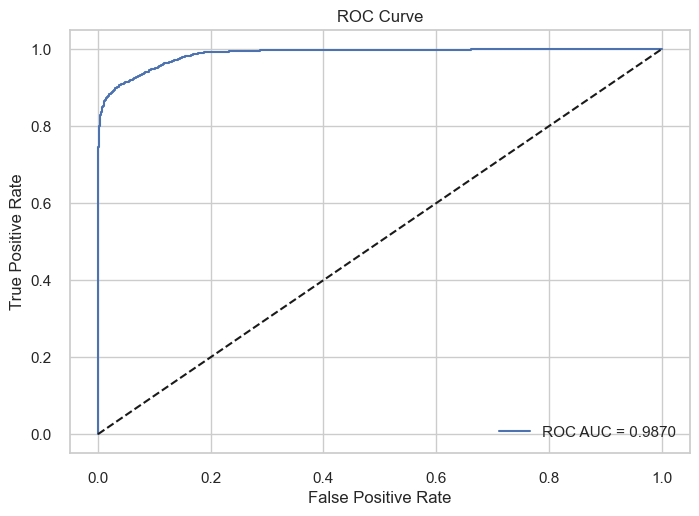

CV ROC AUC: [0.89137151 0.87267981 0.88812506 0.87815435 0.89193019]



In [9]:
# Code Block 11

vartrain = X_train
vartest = X_test
model = RandomForestClassifier(max_depth = 12, random_state=21)

train_and_evaluate(vartrain, vartrain, y_train, y_train, model)

Iteration 1: Accuracy = 0.7631
Iteration 2: Accuracy = 0.7755
Iteration 3: Accuracy = 0.7943
Iteration 4: Accuracy = 0.8008
Iteration 5: Accuracy = 0.7997
Iteration 6: Accuracy = 0.8047
Iteration 7: Accuracy = 0.8070
Iteration 8: Accuracy = 0.8070
Iteration 9: Accuracy = 0.8129
Iteration 10: Accuracy = 0.8132
Iteration 11: Accuracy = 0.8188
Iteration 12: Accuracy = 0.8165
Iteration 13: Accuracy = 0.8180
Iteration 14: Accuracy = 0.8160
Iteration 15: Accuracy = 0.8177
Iteration 16: Accuracy = 0.8194
Iteration 17: Accuracy = 0.8174
Iteration 18: Accuracy = 0.8191
Iteration 19: Accuracy = 0.8171
Iteration 20: Accuracy = 0.8196
Iteration 21: Accuracy = 0.8160
Iteration 22: Accuracy = 0.8191
Iteration 23: Accuracy = 0.8180
Iteration 24: Accuracy = 0.8171


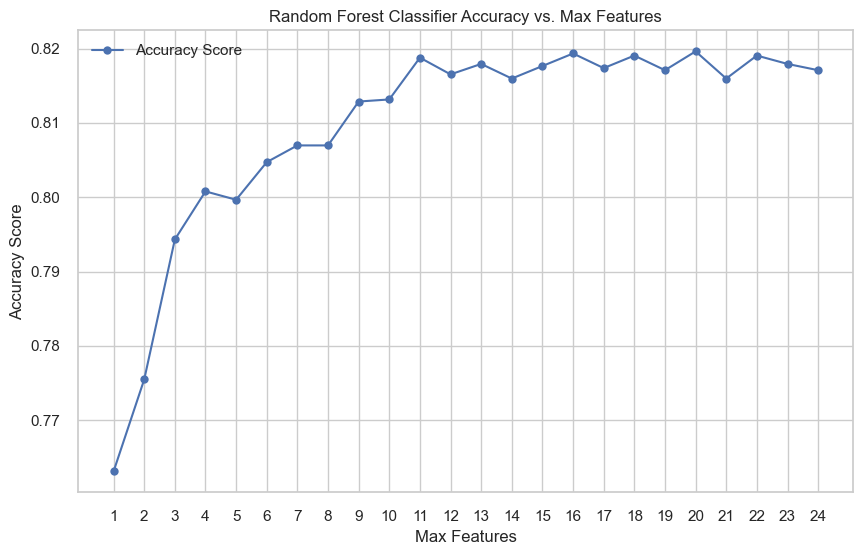

In [10]:
# Code block 12

# Range of max_features values to explore
max_features_values = range(1, 25)

# Initialize an empty list to store accuracy scores
scores = []

# Iterate over each max_features value
for max_features in max_features_values:
    # Initialize the RandomForestClassifier with specified parameters
    classifier = RandomForestClassifier(max_depth=12, max_features=max_features, random_state=21)
    
    # Fit the model to the training data
    classifier.fit(X_train, y_train)
    
    # Evaluate the model on the test data and store the accuracy score
    accuracy = classifier.score(X_test, y_test)
    scores.append(accuracy)
    
    # Print the accuracy for the current max_features value
    print(f"Iteration {max_features}: Accuracy = {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, scores, '-o', label='Accuracy Score')
plt.xlabel('Max Features')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Classifier Accuracy vs. Max Features')
plt.xticks(max_features_values)
plt.grid(True)
plt.legend()
plt.show()

Accuracy Score: 0.9416

Confusion Matrix:
[[5194  143]
 [ 341 2613]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5337
           1       0.95      0.88      0.92      2954

    accuracy                           0.94      8291
   macro avg       0.94      0.93      0.94      8291
weighted avg       0.94      0.94      0.94      8291

ROC AUC Score: 0.9851



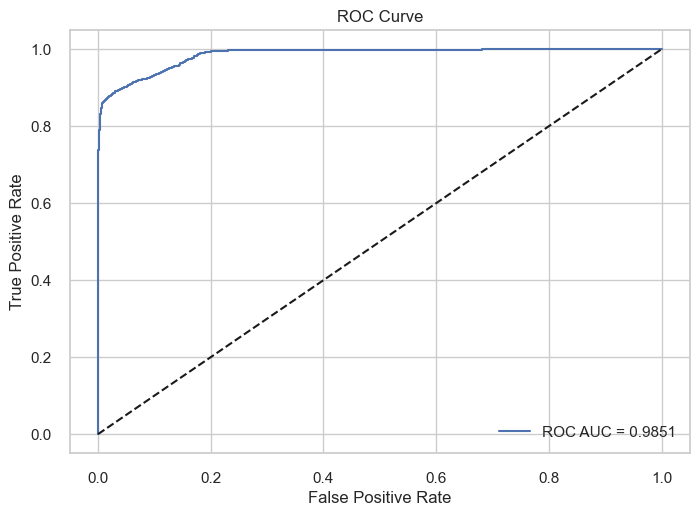

CV ROC AUC: [0.89234745 0.87866597 0.88916773 0.88091047 0.89180729]



In [11]:
# Code Block 13

model = RandomForestClassifier(max_depth = 12, max_features = 20, random_state=21)

train_and_evaluate(vartrain, vartrain, y_train, y_train, model)

Iteration 1: Accuracy = 0.7780
Iteration 20: Accuracy = 0.8168
Iteration 50: Accuracy = 0.8188
Iteration 100: Accuracy = 0.8196
Iteration 150: Accuracy = 0.8182
Iteration 500: Accuracy = 0.8180


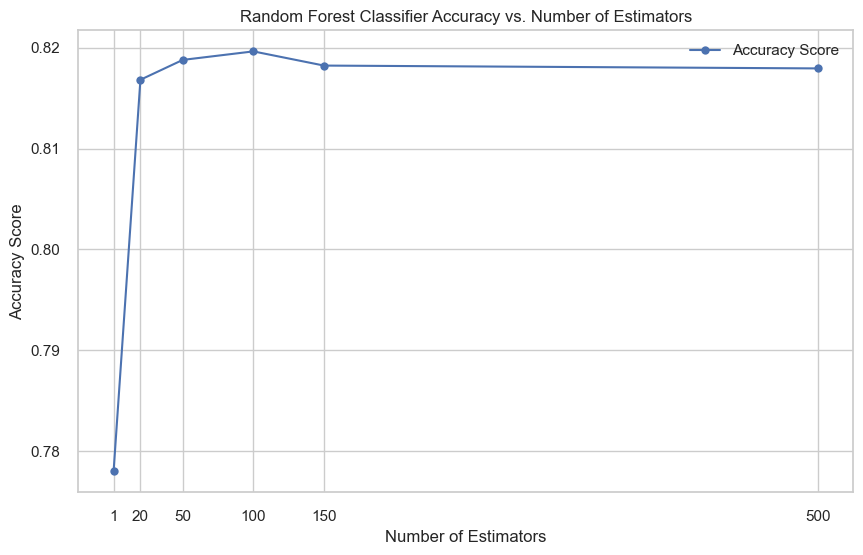

In [12]:
# Code block 14

# Define the values for n_estimators to explore
estimators_values = [1, 20, 50, 100, 150, 500]

# Initialize an empty list to store accuracy scores
scores = []

# Iterate over each value of n_estimators
for n_estimators in estimators_values:
    # Initialize the RandomForestClassifier with specified parameters
    classifier = RandomForestClassifier(max_depth=12, max_features=20, n_estimators=n_estimators, random_state=21)
    
    # Fit the model to the training data
    classifier.fit(X_train, y_train)
    
    # Evaluate the model on the test data and store the accuracy score
    accuracy = classifier.score(X_test, y_test)
    scores.append(accuracy)
    
    # Print the accuracy for the current value of n_estimators
    print(f"Iteration {n_estimators}: Accuracy = {accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(estimators_values, scores, '-o', label='Accuracy Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Classifier Accuracy vs. Number of Estimators')
plt.xticks(estimators_values)
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# Code Block 15

model = RandomForestClassifier(max_depth = 12, max_features = 20, n_estimators = 100, random_state=21)

train_and_evaluate(vartrain, vartrain, y_train, y_train, model, verbose=False)

Accuracy: 0.9416, Recall: 0.8846, Precision: 0.9481, ROC AUC: 0.9851


#### 5.3 Fine-tune the model to find the DECISION model

In [14]:
# Code block 16

# Define the class weights to explore
class_weights = [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}, 
                 {0: 1, 1: 20}, {0: 1, 1: 25}, {0: 1, 1: 30}, {0: 1, 1: 50}, {0: 1, 1: 100}]

# Iterate over each class weight
for weight in class_weights:
    print('----------------------')
    model_title = "Model with Class Weight: " + str(weight)
    print(model_title)
    print('')
    
    # Initialize the RandomForestClassifier with specified parameters
    model = RandomForestClassifier(max_depth=12, max_features=20, n_estimators=100, class_weight=weight, random_state=21)
    
    # Train and evaluate the model
    train_and_evaluate(X_train, X_test, y_train, y_test, model, verbose=False)

print('----------------------')

----------------------
Model with Class Weight: None

Accuracy: 0.8196, Recall: 0.7468, Precision: 0.7612, ROC AUC: 0.8872
----------------------
Model with Class Weight: balanced

Accuracy: 0.8255, Recall: 0.7856, Precision: 0.7535, ROC AUC: 0.8876
----------------------
Model with Class Weight: {0: 1, 1: 2}

Accuracy: 0.8233, Recall: 0.7878, Precision: 0.7480, ROC AUC: 0.8882
----------------------
Model with Class Weight: {0: 1, 1: 3}

Accuracy: 0.8261, Recall: 0.8061, Precision: 0.7449, ROC AUC: 0.8888
----------------------
Model with Class Weight: {0: 1, 1: 5}

Accuracy: 0.8244, Recall: 0.8129, Precision: 0.7388, ROC AUC: 0.8858
----------------------
Model with Class Weight: {0: 1, 1: 10}

Accuracy: 0.8073, Recall: 0.8426, Precision: 0.6986, ROC AUC: 0.8801
----------------------
Model with Class Weight: {0: 1, 1: 20}

Accuracy: 0.7217, Recall: 0.9065, Precision: 0.5792, ROC AUC: 0.8751
----------------------
Model with Class Weight: {0: 1, 1: 25}

Accuracy: 0.6894, Recall: 0.92

Accuracy Score: 0.8129

Confusion Matrix:
[[1853  386]
 [ 279 1036]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      2239
           1       0.73      0.79      0.76      1315

    accuracy                           0.81      3554
   macro avg       0.80      0.81      0.80      3554
weighted avg       0.82      0.81      0.81      3554

ROC AUC Score: 0.8804



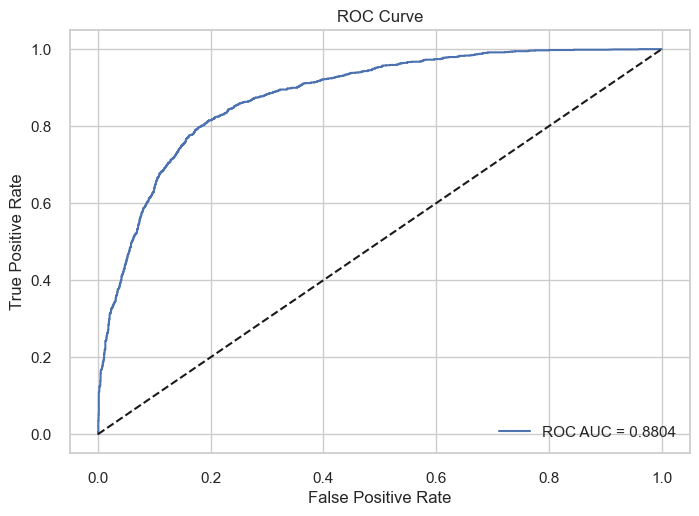

CV ROC AUC: [0.88517922 0.86311734 0.87235905 0.87030623 0.88285387]



In [43]:
# Code Block 17

model = RandomForestClassifier(max_depth = 12, max_features = 9, n_estimators = 20, class_weight={0: 1, 1: 3})

train_and_evaluate(vartrain, vartest, y_train, y_test, model)

In [44]:
# Code block 18

# Define the grid of hyperparameters to search over
param_grid = {
    "max_depth": [9, 11, 13, 15, 19, 21],
    "criterion": ['gini', 'entropy'],
    "n_estimators": [20],
    "max_features": [11, 13, 17, 21],
    "class_weight": [None]
}

# Initialize the base RandomForestClassifier model
base_model = RandomForestClassifier(random_state=21, n_jobs=-2)

# Perform grid search using cross-validation
grid_search = GridSearchCV(base_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and accuracy score
print("Tuned Hyperparameters (Best Parameters): ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

Tuned Hyperparameters (Best Parameters):  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 17, 'n_estimators': 20}
Best Accuracy Score:  0.824869865797627


Accuracy Score: 0.8129

Confusion Matrix:
[[1918  321]
 [ 344  971]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2239
           1       0.75      0.74      0.74      1315

    accuracy                           0.81      3554
   macro avg       0.80      0.80      0.80      3554
weighted avg       0.81      0.81      0.81      3554

ROC AUC Score: 0.8822



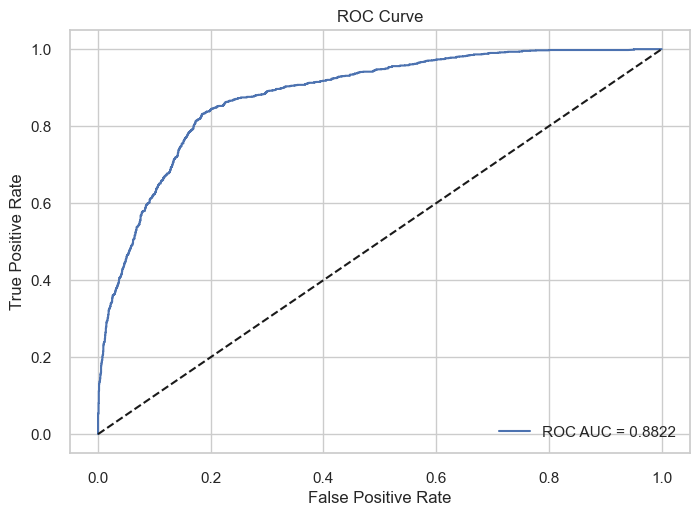

CV ROC AUC: [0.89008267 0.87647035 0.88719499 0.87417638 0.89331776]



In [45]:
# Code Block 19

#Set the model properties
model = RandomForestClassifier(max_depth = 9, max_features = 17, n_estimators = 20, class_weight=None, criterion = 'entropy', random_state=21)

train_and_evaluate(vartrain, vartest, y_train, y_test, model)

### Section 6: Cost Benefit Analysis

#### 6.1 Create a Summary Table

In [15]:
# Code Block 23

model = [
    # Logistic Regression - 2 models
    (X_train_sc, X_test_sc, y_train, 'log_opt', 'Logistic',
     LogisticRegression(random_state=21, C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs')),
    (X_train_sc, X_test_sc, y_train, 'log_dec', 'Logistic',
     LogisticRegression(C=0.1, class_weight={0: 1, 1: 4}, penalty='l1', solver='liblinear', random_state=21)),

    # Decision Tree - 2 models
    (X_train, X_test, y_train, 'dt_opt', 'DecisionTree',
     DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10)),
    (X_train, X_test, y_train, 'dt_dec', 'DecisionTree',
     DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4, random_state=42)),

    # Random Forest - 2 models
    (X_train, X_test, y_train, 'rf_opt', 'RandomForest',
     RandomForestClassifier(max_depth=9, max_features=17, n_estimators=20, class_weight=None, criterion='entropy', random_state=21)),
    (X_train, X_test, y_train, 'rf_dec', 'RandomForest',
     RandomForestClassifier(max_depth=12, max_features=20, n_estimators=100, class_weight={0: 1, 1: 3}, random_state=21))
]

cm_all = pd.DataFrame(columns=['Actual', 'Model', 'Type', 'pred_NoBurglary', 'pred_Burglary', 'Score', 'Recall', 'Precision', 'F1'])

for tr, tst, yt, n, mod, m in model:
    m.fit(tr, yt)
    model_pred = m.predict(tst)
    model_prob = m.predict_proba(tst)
    score = m.score(tst, y_test)
    score_format = '{0:.4f}'.format(score)

    recall = recall_score(y_test, model_pred)
    recall_format = '{0:.4f}'.format(recall)

    f1 = f1_score(y_test, model_pred)
    f1_format = '{0:.4f}'.format(f1)

    precision = precision_score(y_test, model_pred)
    precision_format = '{0:.4f}'.format(precision)

    y_pred_prob = m.predict_proba(tst)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Store these variables in a way that doesn't use exec() if possible, exec() is generally best avoided
    exec(f'fpr_{n} = fpr')
    exec(f'tpr_{n} = tpr')
    exec(f'thresholds_{n} = thresholds')
    exec(f'{n} = n')

    # Create confusion matrix and add 'Actual' column
    cm = pd.DataFrame(confusion_matrix(y_test, model_pred), index=['no_burglary', 'burglary'], columns=['pred_NoBurglary', 'pred_Burglary'])
    cm.reset_index(inplace=True)
    cm.rename(columns={'index': 'Actual'}, inplace=True)

    cm['Model'] = mod
    cm['Type'] = n
    cm['Score'] = score_format
    cm['Recall'] = recall_format
    cm['Precision'] = precision_format
    cm['F1'] = f1_format

    # Concatenate the current confusion matrix with the overall DataFrame
    cm_all = pd.concat([cm_all, cm], axis=0, ignore_index=True)

    print(n + " - Score: " + str(score_format) +
          " - Recall: " + str(recall_format) +
          " - Precision: " + str(precision_format) +
          " - F1: " + str(f1_format))
    print('------------------------------------------------------------------------')

# Display the final DataFrame
display(cm_all)
print('------------------------------------------------------------------------')

log_opt - Score: 0.8025 - Recall: 0.7110 - Precision: 0.7438 - F1: 0.7271
------------------------------------------------------------------------
log_dec - Score: 0.7757 - Recall: 0.8829 - Precision: 0.6436 - F1: 0.7445
------------------------------------------------------------------------
dt_opt - Score: 0.8044 - Recall: 0.7711 - Precision: 0.7202 - F1: 0.7448
------------------------------------------------------------------------
dt_dec - Score: 0.8061 - Recall: 0.7741 - Precision: 0.7220 - F1: 0.7472
------------------------------------------------------------------------
rf_opt - Score: 0.8129 - Recall: 0.7384 - Precision: 0.7515 - F1: 0.7449
------------------------------------------------------------------------
rf_dec - Score: 0.8261 - Recall: 0.8061 - Precision: 0.7449 - F1: 0.7743
------------------------------------------------------------------------


,Actual,Model,Type,pred_NoBurglary,pred_Burglary,Score,Recall,Precision,F1
0,no_burglary,Logistic,log_opt,1917,322,0.8025,0.7110,0.7438,0.7271
1,burglary,Logistic,log_opt,380,935,0.8025,0.7110,0.7438,0.7271
2,no_burglary,Logistic,log_dec,1596,643,0.7757,0.8829,0.6436,0.7445
3,burglary,Logistic,log_dec,154,1161,0.7757,0.8829,0.6436,0.7445
4,no_burglary,DecisionTree,dt_opt,1845,394,0.8044,0.7711,0.7202,0.7448
5,burglary,DecisionTree,dt_opt,301,1014,0.8044,0.7711,0.7202,0.7448
6,no_burglary,DecisionTree,dt_dec,1847,392,0.8061,0.7741,0.7220,0.7472
7,burglary,DecisionTree,dt_dec,297,1018,0.8061,0.7741,0.7220,0.7472
8,no_burglary,RandomForest,rf_opt,1918,321,0.8129,0.7384,0.7515,0.7449
9,burglary,RandomForest,rf_opt,344,971,0.8129,0.7384,0.7515,0.7449


------------------------------------------------------------------------


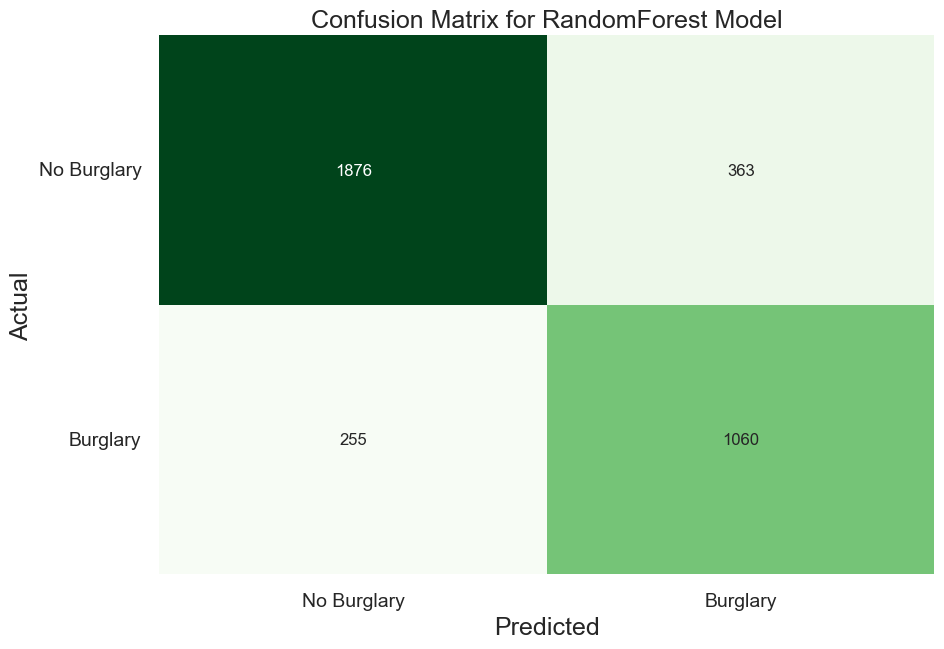

In [48]:
# Code Block 24

# Set
rf_dec = RandomForestClassifier(max_depth=12, max_features=20, n_estimators=100, class_weight={0: 1, 1: 3}, random_state=21)

# Fit 
rf_dec.fit(X_train, y_train)

# Predict 
y_pred = rf_dec.predict(X_test)

# Assess
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))

# Using seaborn to create a more visually appealing confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
label_font = {'size':'18'}
plt.xlabel('Predicted', fontdict=label_font)
plt.ylabel('Actual', fontdict=label_font)
plt.title('Confusion Matrix for RandomForest Model', fontdict=label_font)
tick_labels = ['No Burglary', 'Burglary']
plt.xticks([0.5, 1.5], tick_labels, rotation=0, fontsize=14)
plt.yticks([0.5, 1.5], tick_labels, rotation=0, fontsize=14)
plt.show()

#### 6.2 Understanding the additional officer hours for making a wrong decision

For Random Forest DECISION:
- False Negative: 255 × 3 = 765 additional officer hours
- False Positive: 363 × 1=363 = 183 additional officer hours
- Total additional officer hours = 765 + 363 = 1,128
- Therefore, the Random Forest DECISION model will add an additional 1,128 officer hours.

#### 6.3 Creating the additional officer hours for making a wrong prediction

In [16]:
# Code Block 25

# Calculate the additional hours for false predictions

# noburglary_hrs when actual is no burglary, otherwise 0
cm_all['noburglary_hrs'] = np.where(cm_all['Actual'] == 'no_burglary', cm_all['pred_Burglary'] * 1, 0).astype(int)

# burglary_hrs when actual is burglary, otherwise 0
cm_all['burglary_hrs'] = np.where(cm_all['Actual'] == 'burglary', cm_all['pred_NoBurglary'] * 3, 0).astype(int)

cm_all['pred_NoBurglary'] = cm_all['pred_NoBurglary'].astype(float)
cm_all['pred_Burglary'] = cm_all['pred_Burglary'].astype(float)
cm_all['Score'] = cm_all['Score'].astype(float)
cm_all['Recall'] = cm_all['Recall'].astype(float)
cm_all['Precision'] = cm_all['Precision'].astype(float)
cm_all['F1'] = cm_all['F1'].astype(float)
cm_all['noburglary_hrs'] = cm_all['noburglary_hrs'].astype(int)
cm_all['burglary_hrs'] = cm_all['burglary_hrs'].astype(int)

cm_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Actual           12 non-null     object 
 1   Model            12 non-null     object 
 2   Type             12 non-null     object 
 3   pred_NoBurglary  12 non-null     float64
 4   pred_Burglary    12 non-null     float64
 5   Score            12 non-null     float64
 6   Recall           12 non-null     float64
 7   Precision        12 non-null     float64
 8   F1               12 non-null     float64
 9   noburglary_hrs   12 non-null     int32  
 10  burglary_hrs     12 non-null     int32  
dtypes: float64(6), int32(2), object(3)
memory usage: 1.1+ KB


#### 6.4 Group the additional officer hours for making a wrong prediction

In [17]:
# Code Block 26

# Calculate the sum noburglary_hrs and burglary_hrs (reset the index)
cm_all_loss = cm_all.groupby('Type')[['noburglary_hrs', 'burglary_hrs']].sum().reset_index()
cm_all_loss

,Type,noburglary_hrs,burglary_hrs
0,dt_dec,392,891
1,dt_opt,394,903
2,log_dec,643,462
3,log_opt,322,1140
4,rf_dec,363,765
5,rf_opt,321,1032


In [18]:
# Code Block 27

# Calculate the mean for Score, Recall, Precision, F1 (reset the index)
cm_all_score = cm_all.groupby('Type')[['Score', 'Recall', 'Precision', 'F1']].mean().reset_index()
cm_all_score

,Type,Score,Recall,Precision,F1
0,dt_dec,0.8061,0.7741,0.7220,0.7472
1,dt_opt,0.8044,0.7711,0.7202,0.7448
2,log_dec,0.7757,0.8829,0.6436,0.7445
3,log_opt,0.8025,0.7110,0.7438,0.7271
4,rf_dec,0.8261,0.8061,0.7449,0.7743
5,rf_opt,0.8129,0.7384,0.7515,0.7449


In [19]:
# Code Block 28

# Include the Model column by calculating the first record
cm_all_model = cm_all.groupby('Type')['Model'].first().reset_index()
cm_all_model

,Type,Model
0,dt_dec,DecisionTree
1,dt_opt,DecisionTree
2,log_dec,Logistic
3,log_opt,Logistic
4,rf_dec,RandomForest
5,rf_opt,RandomForest


In [20]:
# Code Block 29

# Merge the three different calculated groupings together and name it model_cost
model_cost = cm_all_loss.merge(cm_all_score, on='Type').merge(cm_all_model, on='Type')

# For model_cost, create a new column named pred_hrs that adds noburglary_hrs and burglary_hrs together. 
model_cost['pred_hrs'] = model_cost['noburglary_hrs'] + model_cost['burglary_hrs']
model_cost.head(1)

,Type,noburglary_hrs,burglary_hrs,Score,Recall,Precision,F1,Model,pred_hrs
0,dt_dec,392,891,0.8061,0.7741,0.722,0.7472,DecisionTree,1283


### Section 7: Summarize and Visualize the Result

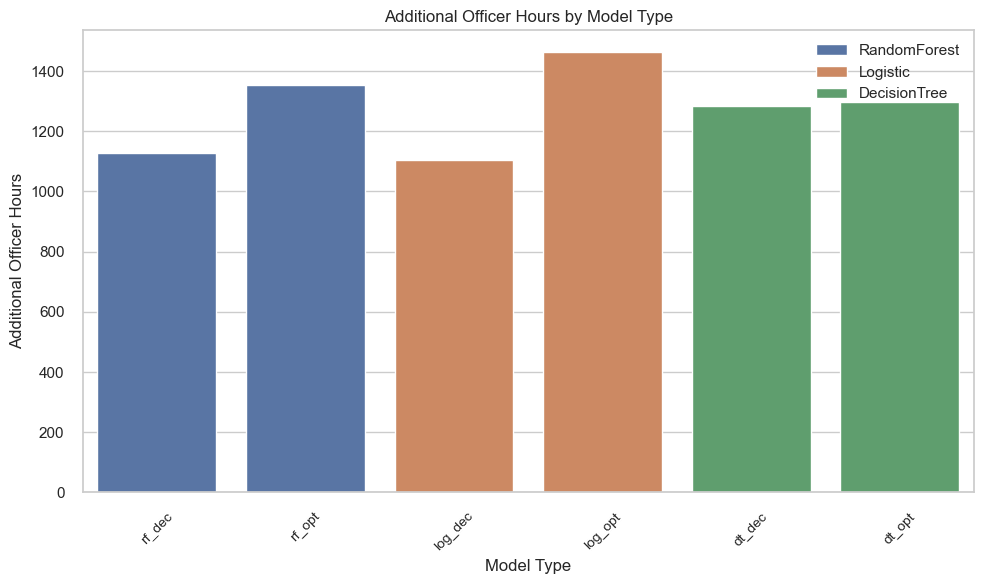

In [21]:
# Code Block 30

model_cost = model_cost.sort_values(by='Model', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.barplot(y = "pred_hrs", x = "Type",  data = model_cost, hue= 'Model', palette = 'deep', dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize='10')
plt.legend(loc="upper right")
plt.title('Additional Officer Hours by Model Type')
plt.xlabel('Model Type')
plt.ylabel('Additional Officer Hours')
plt.xticks(rotation=45)
plt.tight_layout()

In [22]:
# Code Block 31

model_cost[model_cost['Model']=='RandomForest']

,Type,noburglary_hrs,burglary_hrs,Score,Recall,Precision,F1,Model,pred_hrs
4,rf_dec,363,765,0.8261,0.8061,0.7449,0.7743,RandomForest,1128
5,rf_opt,321,1032,0.8129,0.7384,0.7515,0.7449,RandomForest,1353


#### Model Evaluation for Canton Police Department

After performing an extensive analysis of various machine learning models, it has been determined that the Random Forest Decision model `rf_dec` stands out as the best model for our needs.

#### Why?

- **Highest Overall Accuracy**: With a score of 0.8261, it has the best accuracy among the models tested.
- **Superior Recall**: At 0.8061, it is the most reliable model for identifying actual burglaries, which is crucial for public safety and resource allocation.
- **Balanced Precision and F1 Score**: Its precision and F1 score reflect a well-balanced model that correctly identifies burglaries without a high rate of false alarms.
- **Efficiency in Resource Utilization**: By reducing the additional officer hours needed for false predictions, `rf_dec` allows the Canton Police Department to allocate their resources more effectively and potentially invest more in preventive measures.

In conclusion, adopting the `rf_dec` model aligns with the department's goal of efficient and accurate burglary prediction, ensuring that officer hours are dedicated to genuine cases, ultimately enhancing the safety and security of the Canton community.

### Section 8: Predict Week 50

In [36]:
# Code Block 32

# Import the dataset named CantonPoliceDept_HW05_Week49.csv
df_canton_new = pd.read_csv('data/CantonPoliceDept_HW05_week49.csv')
df_canton_new.head()

,Index,Subzone,All_comp,FalseAlarm_comp,Arrest_comp,Cleared_comp,NoContact_comp,NoReport_comp,Resolved_comp,Filed_comp,Calls_comp,BurgAlarm_comp,Suspicious_comp,Shots_comp,Intox_comp,Drugs_comp,Assault_comp,Armed_comp,Disturb_comp,Fireworks_comp,Noise_comp,Stalking_comp,call_ALL,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,call_Armed subject,call_Assault,call_Burglar alarm,call_Burglary,call_Disturbance,call_Domestic,call_FW FIREWORKS,call_Fight,call_Loitering,call_Message delivery,call_Noise complaint,call_Possible drugs present,call_Prowler,call_Public Intoxication,call_Shots fired,call_Special residence patrol,call_Special watch,call_Stalking,call_Suspicious activity,call_Trespassing,call_Vandalism,call_Welfare check,disp_15-ARREST,disp_66-CANCEL,disp_9-VERBAL,disp_ADV-ADVICE GIVEN,disp_AST-ASSIST,disp_CI-CITY CITATION,disp_CLR-CLEARED BY DISPATCH,disp_CM-CIVIL MATTER,disp_COMP,disp_DISR,disp_Disregard,disp_Domestic Violence Report,disp_FA-FALSE ALARM,disp_FD-FOUNDED ALARM,disp_FI-FIELD INTERVIEW,disp_Gone on Arrival,disp_IRT Report,disp_K9 Report,disp_MC-STATE MISD CITATION,disp_MDT-BOLO'D MDT,disp_MSG-MESSAGE DELIVERED,disp_N25-NO CONTACT,disp_NR-NO REPORT,disp_Other,disp_PR-PROPERTY RETURNED,disp_RES-RESOLVED,disp_RF-REPORT FILED,disp_Runaway juvenile (entered NCIC),disp_SAT-SETTLED AMONG SELVES,disp_TES-TEST,disp_TI -TOW IN,disp_Truancy,disp_VA Hospital Alarm (Fire),SqFootage,HousingUnits,Population,Population_Male,Population_Female,Worked,Workers who travel to work,Drove alone to Work,Carpooled to Work,Population_3andover,Enrolled in school,"Enrolled in nursery school, preschool",Enrolled in kindergarten,"Enrolled in college, undergraduate years",Graduate or professional school,Not enrolled in school,Households_earnings,Households_wageorsalaryincome,Households_selfemploymentincome,Households_interest_dividends,Households_SSI,Households_publicassistanceincome,MedianAge_Total,MedianAge_Male,MedianAge_Female,HouseholdIncome_Median,HouseholdIncome_Median_25to44,HouseholdIncome_Median_65andover,HouseholdIncome_Median_45to64,Income_PerCapita
0,0,ZONE1A,0,0,0,0,0,0,0,0,154,0,21,0,0,0,0,0,21,0,0,0,22,6,2,1,6,0,5,1,0,0,0,0,0,0,0,0,0,0,0,21,0,0,5,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,8,3,0,0,1,0,0,1,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,6,0,0,2,2,0,0,0,0,0,0,2.196943e+07,77,2866,0.481158,0.518842,1097,0.967183,0.830447,0.058341,2763,0.264206,0.020992,0.000000,0.031849,0.027506,0.735794,905,0.955801,0.131492,0.171271,0.181215,0.028729,33,27,40,25994,31089.00000,43746,27679,16862
1,1,ZONE1B,0,0,0,0,0,0,0,0,261,9,54,0,9,9,9,0,9,0,9,0,29,6,1,5,9,4,4,3,0,0,0,0,0,0,0,0,0,0,0,32,0,1,4,1,1,11,0,0,0,1,1,1,0,2,0,0,0,0,7,0,1,1,8,0,0,1,0,2,1,0,0,0,0,0,4,0,0,0,0,0,0,0,0,4,2,0,0,3,7,0,0,0,0,0,0,2.330865e+07,68,3417,0.575066,0.424934,2025,0.984198,0.680988,0.225185,3295,0.301062,0.008801,0.004552,0.181184,0.040668,0.698938,1285,1.000000,0.062257,0.178210,0.021790,0.013230,37,38,34,52050,47114.00000,81316,55827,22271
2,2,ZONE1C,0,0,0,0,0,0,0,0,300,0,100,10,0,0,10,0,50,0,10,0,30,2,9,2,3,3,6,4,0,0,0,0,0,0,0,0,0,0,0,29,0,1,3,0,1,2,0,1,1,1,1,0,0,0,1,0,0,0,11,1,0,5,1,2,0,0,4,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,10,0,0,5,2,0,0,0,0,0,0,6.501904e+06,30,626,0.322684,0.677316,317,1.000000,0.807571,0.164038,606,0.145215,0.044554,0.000000,0.023102,0.000000,0.854785,229,1.000000,0.296943,0.056769,0.165939,0.021834,45,37,46,22150,65078.29167,18068,34792,14181
3,3,ZONE1D,0,0,0,0,0,0,0,0,333,0,54,18,27,0,9,0,9,0,0,9,37,5,2,5,5,6,5,9,0,0,0,0,0,0,0,0,0,0,0,37,0,1,9,0,0,7,0,0,0,0,0,0,0,3,2,0,0,1,6,1,1,6,2,1,1,1,2,0,1,0,0,0,0,0,9,0,0,0,0,0,0,0,0,9,4,0,0,3,4,0,0,0,0,0,0,1.306158e+08,182,4522,0.507519,0.492481,2366,0.988588,0.883770,0.087489,4358,0.267324,0.011014,0.006884,0.109224,0.028683,0.732676,1657,1.000000,0.042245,0.166566,0.064575,0.050694,31,28,32,33225,35873.00000,32084,44433,20857
4,4,ZONE2A,0,0,0,0,0,0,0,0,132,0,44,4,4,4,0,0,16,0,4,0,33,8,3,2,3,7,6,4,0,0,0,

In [41]:
# Code Block 33

# Preprocess
X_week49 = df_canton_new.drop(['Subzone', 'YEAR_WEEK', 'SUB_YEAR_WEEK', 'call_ALL_target', 'call_Burglary_target', 'ActualBurg', 'BurgStatus', 'BurgStatus2', 'PredictedBurgStatus'], axis=1, errors='ignore')

# Set
rf_dec = RandomForestClassifier(max_depth=12, max_features=20, n_estimators=100, class_weight={0: 1, 1: 3}, random_state=21)

# Fit 
rf_dec.fit(X_train, y_train)

# Predict 
df_canton_new['PredictedBurgStatus'] = rf_dec.predict(X_week49)

# Assess
expected_burglaries = df_week49[df_canton_new['PredictedBurgStatus'] == 1][['Subzone', 'PredictedBurgStatus']]
expected_burglaries


,Subzone,PredictedBurgStatus
1,ZONE1B,1
10,ZONE3E,1
13,ZONE5A,1
14,ZONE5B,1


These predictions suggest that these specific areas are at a higher risk of experiencing burglary incidents during the upcoming week: ZONE1B, ZONE3E, ZONE5A, and ZONE5B. This information is invaluable for strategic planning and resource allocation within the police department.

Given these predictions, the Police Chief should consider allocating more patrol units to the identified high-risk subzones. This can act as a deterrent to potential burglars and help in the quick response to any incidents.

The model's accuracy, precision, recall, and F1 score, as determined during training and validation, provide quantitative measures of its predictive performance. High values in these metrics indicate a reliable model.

It's important to remember that no predictive model is perfect, and there will always be a degree of uncertainty. However, using data-driven approaches for decision-making can significantly enhance the effectiveness and efficiency of police work, leading to better resource allocation and potentially reducing crime rates.